<a href="https://colab.research.google.com/github/reidnclark/volatility-forecast/blob/main/NewVolatilityForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Buying 157.0 shares at $31.83 on 2023-02-23 00:00:00-05:00
Selling 157.0 shares at $29.99 on 2023-04-17 00:00:00-04:00 | Profit/Loss: $-288.88
Buying 174.0 shares at $26.98 on 2023-05-11 00:00:00-04:00
Selling 174.0 shares at $28.72 on 2023-05-30 00:00:00-04:00 | Profit/Loss: $302.76
Buying 128.0 shares at $38.89 on 2023-08-31 00:00:00-04:00
Selling 128.0 shares at $33.45 on 2023-09-18 00:00:00-04:00 | Profit/Loss: $-696.32
Buying 136.0 shares at $31.73 on 2023-11-13 00:00:00-05:00

Total Profit/Loss from Trading Strategy: $-682.44
Final Portfolio Value: $5563.32

Total Profit/Loss from Buy and Hold Strategy: $2564.65
Final Portfolio Value (Buy and Hold): $7564.65
-------
Trading Strategy Return: 11.27%
Buy and Hold Return: 51.29%
-------


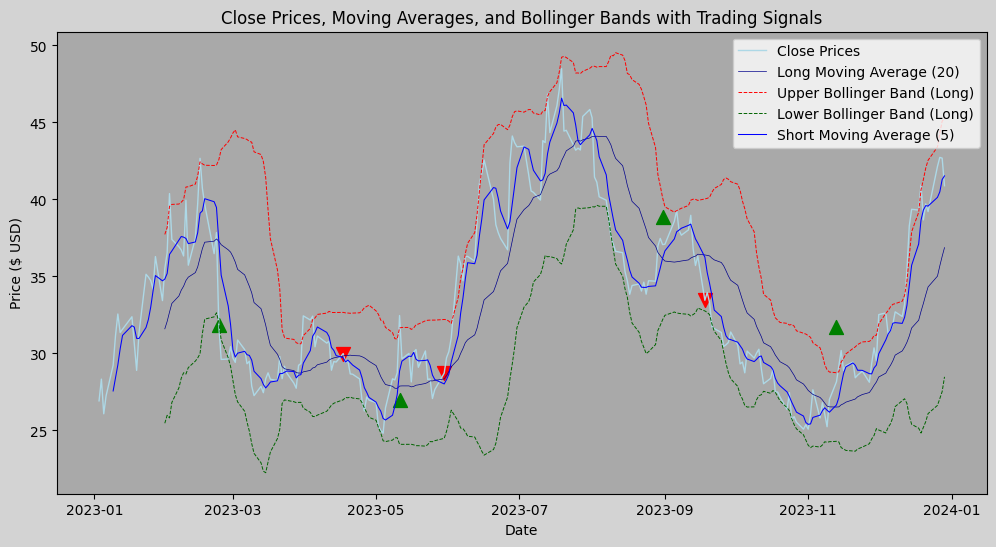


Performance Metrics:
                             Result
Number of Trades             3.0000
Number of Profitable Trades  1.0000
Confidence                   0.3333
Lift                         0.4444

--- Confidence ---
Confidence (P(Profit | Trade)) = Number of Profitable Trades / Number of Trades
Confidence = 1 / 3 = 0.3333
This metric indicates the likelihood that a trade will be profitable based on historical performance.

--- Lift ---
Lift = Number of Profitable Trades / (Number of Trades * Market Profitable Trades)
Lift = 1 / (3 * 0.5)
Lift = 0.4444
This metric shows how much more likely it is to have a profitable trade compared to the market average.


In [529]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Inputs
ticker_input = 'U'
period_start = '2023-01-01'
period_end = '2024-01-01'

# Fetch historical data
ticker_histdata = yf.Ticker(ticker_input).history(start=period_start, end=period_end)
close_prices = (pd.DataFrame(ticker_histdata))['Close']

moving_avg_interval_long = 20  # Long moving average interval
moving_avg_interval_short = 5  # Short moving average interval

def moving_avg(arr, interval):
    moving_avg_list = []
    upper_bollys = []
    lower_bollys = []

    for index in range(len(arr) - interval + 1):
        window = arr[index:index + interval]
        avg = window.mean()
        sdev = window.std()

        upper_bolly = avg + (sdev * 2)
        lower_bolly = avg - (sdev * 2)

        moving_avg_list.append(avg)
        upper_bollys.append(upper_bolly)
        lower_bollys.append(lower_bolly)

    nan_array = np.full(len(arr), np.nan)
    moving_avg_stretched = nan_array.copy()
    upper_bollys_stretched = nan_array.copy()
    lower_bollys_stretched = nan_array.copy()

    moving_avg_stretched[interval - 1:] = moving_avg_list
    upper_bollys_stretched[interval - 1:] = upper_bollys
    lower_bollys_stretched[interval - 1:] = lower_bollys

    return moving_avg_stretched, upper_bollys_stretched, lower_bollys_stretched

# Calculate moving averages and Bollinger Bands
moving_avg_long_stretched, upper_bollys_long_stretched, lower_bollys_long_stretched = moving_avg(close_prices, moving_avg_interval_long)
moving_avg_short_stretched, _, _ = moving_avg(close_prices, moving_avg_interval_short)

def trading_strategy(close_prices, moving_avg_long_stretched, moving_avg_short_stretched,
                     upper_bollys_long_stretched, lower_bollys_long_stretched,
                     initial_capital=5000, threshold=0.2):
    position = 0  # 0 means no position, 1 means holding a position
    shares_owned = 0
    cash = initial_capital
    profits_losses = []
    buy_signals = []
    sell_signals = []

    for i in range(len(close_prices)):
        current_price = close_prices.iloc[i]

        if position == 0 and (current_price < lower_bollys_long_stretched[i] or
                              current_price < lower_bollys_long_stretched[i] + threshold):
            for j in range(i, len(close_prices)):
                if moving_avg_short_stretched[j] > moving_avg_long_stretched[j]:
                    shares_to_buy = cash // current_price
                    if shares_to_buy > 0:
                        position = 1
                        shares_owned = shares_to_buy
                        cash -= shares_to_buy * current_price
                        buy_price = current_price
                        buy_signals.append((close_prices.index[j], buy_price))
                        print(f"Buying {shares_owned} shares at ${round((buy_price),2)} on {close_prices.index[j]}")
                    break

        if position == 1:
            if current_price > upper_bollys_long_stretched[i] or \
               current_price > upper_bollys_long_stretched[i] - threshold:
                for j in range(i, len(close_prices)):
                    if moving_avg_short_stretched[j] < moving_avg_long_stretched[j]:
                        # Use the closing price at the current index for selling
                        selling_price = close_prices.iloc[j]
                        profit_loss = (selling_price - buy_price) * shares_owned
                        profits_losses.append(profit_loss)
                        cash += shares_owned * selling_price
                        sell_signals.append((close_prices.index[j], selling_price))
                        print(f"Selling {shares_owned} shares at ${round((selling_price),2)} on {close_prices.index[j]} | Profit/Loss: ${profit_loss:.2f}")
                        position = 0
                        shares_owned = 0
                        break

    final_value = cash + (shares_owned * close_prices.iloc[-1] if shares_owned > 0 else 0)
    return profits_losses, final_value, buy_signals, sell_signals

# Execute the trading strategy
profits_losses, final_value, buy_signals, sell_signals = trading_strategy(close_prices,
    moving_avg_long_stretched, moving_avg_short_stretched,
    upper_bollys_long_stretched, lower_bollys_long_stretched)

total_profit_loss = sum(profits_losses)
print(f"\nTotal Profit/Loss from Trading Strategy: ${total_profit_loss:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")

# Buy and Hold Strategy
initial_investment = 5000
shares_bought = initial_investment // close_prices.iloc[0]
final_value_buy_hold = shares_bought * close_prices.iloc[-1]
buy_hold_profit_loss = final_value_buy_hold - initial_investment

# Percentage Returns Calculation
trading_strategy_return = (final_value - 5000) / 5000 * 100
buy_hold_return = (final_value_buy_hold - initial_investment) / initial_investment * 100

print(f"\nTotal Profit/Loss from Buy and Hold Strategy: ${buy_hold_profit_loss:.2f}")
print(f"Final Portfolio Value (Buy and Hold): ${final_value_buy_hold:.2f}")
print('-------')
print(f"Trading Strategy Return: {trading_strategy_return:.2f}%")
print(f"Buy and Hold Return: {buy_hold_return:.2f}%")
print('-------')

# Plotting
plt.figure(figsize=(12, 6), facecolor='lightgrey')
plt.gca().set_facecolor('darkgrey')
plt.plot(close_prices.index, close_prices, label='Close Prices', color='lightblue', linewidth=1)
plt.plot(close_prices.index, moving_avg_long_stretched, label=f'Long Moving Average ({moving_avg_interval_long})', color='darkblue', linewidth=0.5)
plt.plot(close_prices.index, upper_bollys_long_stretched, label='Upper Bollinger Band (Long)', color='red', linestyle='--', linewidth=0.7)
plt.plot(close_prices.index, lower_bollys_long_stretched, label='Lower Bollinger Band (Long)', color='darkgreen', linestyle='--', linewidth=0.7)
plt.plot(close_prices.index, moving_avg_short_stretched, label=f'Short Moving Average ({moving_avg_interval_short})', color='blue', linewidth=0.75)

# Highlight buy signals
for buy_date, buy_price in buy_signals:
    plt.scatter(buy_date, buy_price, marker='^', color='green', s=100)

# Highlight sell signals
for sell_date, sell_price in sell_signals:
    plt.scatter(sell_date, sell_price, marker='v', color='red', s=100)

plt.title('Close Prices, Moving Averages, and Bollinger Bands with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price ($ USD)')
plt.legend()
plt.show()

def calculate_metrics(profits_losses):
    num_trades = len(profits_losses)

    # Count profitable trades where profit is greater than 0
    profitable_trades = [p for p in profits_losses if p > 0]
    num_profitable_trades = len(profitable_trades)

    # Calculate Confidence
    confidence = num_profitable_trades / num_trades if num_trades > 0 else 0

    # Assume 50% of trades in the market are profitable
    market_profitable_trades = 0.75  # 50%

    # Calculate Lift
    if num_trades > 0 and market_profitable_trades > 0:
        lift = num_profitable_trades / (num_trades * market_profitable_trades)
    else:
        lift = 0

    return {
        'Number of Trades': num_trades,
        'Number of Profitable Trades': num_profitable_trades,
        'Confidence': confidence,
        'Lift': lift
    }


metrics = calculate_metrics(profits_losses)

# Create a results table
results_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
results_df.columns = ['Result']
results_df = results_df.round(4)

print("\nPerformance Metrics:")
print(results_df)

# Describing the metrics
confidence_value = metrics['Confidence']
lift_value = metrics['Lift']
num_trades = metrics['Number of Trades']
num_profitable_trades = metrics['Number of Profitable Trades']

# Explanation of Confidence
print("\n--- Confidence ---")
print(f"Confidence (P(Profit | Trade)) = Number of Profitable Trades / Number of Trades")
print(f"Confidence = {num_profitable_trades} / {num_trades} = {confidence_value:.4f}")
print("This metric indicates the likelihood that a trade will be profitable based on historical performance.")

# Explanation of Lift
print("\n--- Lift ---")
market_profitable_trades_percentage = 0.5  # Assuming 50% of trades in the market are profitable
print(f"Lift = Number of Profitable Trades / (Number of Trades * Market Profitable Trades)")
print(f"Lift = {num_profitable_trades} / ({num_trades} * {market_profitable_trades_percentage})")
print(f"Lift = {lift_value:.4f}")
print("This metric shows how much more likely it is to have a profitable trade compared to the market average.")

